<a href="https://colab.research.google.com/github/hc07180011/testing-cv/blob/main/flicker_detection/flicker_detection/colab/model0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!git clone https://github.com/hc07180011/testing-cv.git

Cloning into 'testing-cv'...
remote: Enumerating objects: 1635, done.
remote: Counting objects: 100% (1299/1299), done.
remote: Compressing objects: 100% (990/990), done.
remote: Total 1635 (delta 771), reused 678 (delta 289), pack-reused 336
Receiving objects: 100% (1635/1635), 114.01 MiB | 29.94 MiB/s, done.
Resolving deltas: 100% (930/930), done.


In [ ]:
%cd testing-cv/flicker_detection/flicker_detection/
%pip install -r requirements.txt
%pip install -r requirements_dev.txt
%pip install tensorflow-addons
%pip install coloredlogs rich


/content/testing-cv/flicker_detection/flicker_detection
     |████████████████████████████████| 46 kB 3.7 MB/s 
     |████████████████████████████████| 51 kB 5.1 MB/s 
     |████████████████████████████████| 890 kB 49.7 MB/s 
     |████████████████████████████████| 155 kB 62.3 MB/s 
     |████████████████████████████████| 4.1 MB 50.9 MB/s 
     |████████████████████████████████| 4.1 MB 49.9 MB/s 
     |████████████████████████████████| 86 kB 6.6 MB/s 
     |████████████████████████████████| 61 kB 6.3 MB/s 
     |████████████████████████████████| 1.3 MB 49.2 MB/s 
     |████████████████████████████████| 1.1 MB 55.7 MB/s 
     |████████████████████████████████| 13.3 MB 23.7 MB/s 
     |████████████████████████████████| 11.2 MB 49.9 MB/s 
ERROR: Could not find a version that satisfies the requirement numpy==1.22.1 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11

In [ ]:
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110


Looking in indexes: https://pypi.org/simple, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 314.2 MB 34 kB/s 


## Mount drive

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## logging.py

In [ ]:
import sys
import logging

from rich.logging import RichHandler


def init_logger() -> None:
    logger = logging.getLogger("rich")

    FORMAT = "%(name)s[%(process)d] " + \
        "%(processName)s(%(threadName)s) " + \
        "%(module)s:%(lineno)d  %(message)s"

    logger.setLevel(logging.DEBUG)
    formatter = logging.Formatter(
        FORMAT,
        datefmt="%Y%m%d %H:%M:%S"
    )
    logging.basicConfig(
        level="NOTSET", format=FORMAT, handlers=[RichHandler()]
    )

    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    ch.setFormatter(formatter)

    logger.addHandler(ch)

    logging.info("Initializing ok.")

## keras.py

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc,roc_auc_score
from tensorflow.keras import backend as K

logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("tensorflow").setLevel(logging.WARNING)

plots_folder = "/content/drive/MyDrive/google_cv/flicker_detection/plots/"


"""
keras metrics api:
https://keras.io/api/metrics/
custom sensitivity specificity:
https://stackoverflow.com/questions/55640149/error-in-keras-when-i-want-to-calculate-the-sensitivity-and-specificity
custom auc:
https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
"""

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras


def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

# TODO
def auroc(y_true, y_pred):
    """
    https://www.codegrepper.com/code-examples/python/auc+callback+keras
    """
    if tf.math.count_nonzero(y_true) == 0:
        return tf.cast(0.0, tf.float32)
    return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.float32) 

def fbeta(y_true, y_pred, beta=2):
    y_pred = K.clip(y_pred, 0, 1)

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    num = (1 + beta ** 2) * (p * r)
    den = (beta ** 2 * p + r + K.epsilon())
    return K.mean(num / den)


def matthews_correlation_coefficient(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())


def equal_error_rate(y_true, y_pred):
    n_imp = tf.math.count_nonzero(tf.equal(y_true, 0), dtype=tf.float32) + tf.constant(K.epsilon())
    n_gen = tf.math.count_nonzero(tf.equal(y_true, 1), dtype=tf.float32) + tf.constant(K.epsilon())

    scores_imp = tf.boolean_mask(y_pred, tf.equal(y_true, 0))
    scores_gen = tf.boolean_mask(y_pred, tf.equal(y_true, 1))

    loop_vars = (tf.constant(0.0), tf.constant(1.0), tf.constant(0.0))
    cond = lambda t, fpr, fnr: tf.greater_equal(fpr, fnr)
    body = lambda t, fpr, fnr: (
        t + 0.001,
        tf.divide(tf.math.count_nonzero(tf.greater_equal(scores_imp, t), dtype=tf.float32), n_imp),
        tf.divide(tf.math.count_nonzero(tf.less(scores_gen, t), dtype=tf.float32), n_gen)
    )
    t, fpr, fnr = tf.while_loop(cond, body, loop_vars, back_prop=False)
    eer = (fpr + fnr) / 2

    return eer




class Model:
    """
    callbacks:
    https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    """
    def __init__(
        self,
        model: tf.keras.models.Sequential,
        loss: str,
        optimizer: tf.keras.optimizers,
        metrics = tuple((
            "accuracy",
            precision,
            recall,
            f1,
            # auroc,
            fbeta,
            specificity,
            negative_predictive_value,
            matthews_correlation_coefficient,
            equal_error_rate
        )),
        summary=True
    ) -> None:
        self.model = model
        self.model.compile(
            loss=loss,
            optimizer=optimizer,
            metrics=metrics
        )
        if summary:
            print(self.model.summary())

    def train(
        self,
        X_train: np.array,
        y_train: np.array,
        epochs: int,
        validation_split: float,
        batch_size: int,
        model_path: str = "/content/drive/MyDrive/google_cv/flicker_detection/models/model0.h5",
        monitor: str = "val_f1",
        mode: str = "max"
    ) -> None:
        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            validation_split=validation_split,
            batch_size=batch_size,
            callbacks=[
                tf.keras.callbacks.ModelCheckpoint(
                    model_path,
                    save_best_only=True,
                    monitor=monitor,
                    mode=mode
                )
            ]
        )

    def plot_history(self, key: str, title=None) -> None:
        plt.figure(figsize=(16, 4), dpi=200)
        plt.plot(self.history.history["{}".format(key)])
        plt.plot(self.history.history["val_{}".format(key)])
        plt.legend(["{}".format(key), "val_{}".format(key)])
        plt.xlabel("# Epochs")
        plt.ylabel("{}".format(key))
        if title:
            plt.title("{}".format(title))
        plt.savefig(plots_folder+"{}.png".format(key))
        plt.close()


class InferenceModel:

    def __init__(
        self,
        model_path: str,
        custom_objects: dict = {
            "precision":precision,
            "recall":recall,
            "f1":f1,
            # "auroc":auroc,
            "fbeta":fbeta,
            "specificity":specificity,
            "negative_predictive_value":negative_predictive_value,
            "matthews_correlation_coefficient":matthews_correlation_coefficient,
            "equal_error_rate":equal_error_rate
        }
    ) -> None:
        self.model = tf.keras.models.load_model(
            model_path,
            custom_objects=custom_objects
        )

    def predict(self, X_test: np.array) -> np.array:
        y_pred = self.model.predict(X_test)
        return y_pred.flatten()

    def evaluate(self, y_true: np.array, y_pred: np.array) -> None:
        threshold_range = np.arange(0.1, 1.0, 0.001)

        f1_scores = list()
        for lambda_ in threshold_range:
            f1_scores.append(f1_score(y_true, (y_pred > lambda_).astype(int)))
        
        print("Max f1: {:.4f}, at thres = {:.4f}".format(
            np.max(f1_scores), threshold_range[np.argmax(f1_scores)]
        ))
        # logging.info("Max f1: {:.4f}, at thres = {:.4f}".format(
        #     np.max(f1_scores), threshold_range[np.argmax(f1_scores)]
        # ))

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        plt.plot([0, 1], [0, 1], linestyle="dashed")
        plt.plot(fpr, tpr, marker="o")
        plt.plot([0, 0, 1], [0, 1, 1], linestyle="dashed", c="red")
        plt.legend([
            "No Skill",
            "ROC curve (area = {:.2f})".format(auc(fpr, tpr)),
            "Perfect"
        ])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.savefig(os.path.join(plots_folder,"roc_curve.png"))
        plt.close()

        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        plt.plot([0, 1], [0, 0], linestyle="dashed")
        plt.plot(recall, precision, marker="o")
        plt.legend([
            "No Skill",
            "Model"
        ])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-recall Curve")
        plt.savefig(os.path.join(plots_folder,"pc_curve.png"))

        print(confusion_matrix(
            y_true,
            (y_pred > threshold_range[np.argmax(f1_scores)]).astype(int)
        ))

## facenet.py

In [ ]:
import os
import cv2
import json

from tensorflow.keras import metrics
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import resnet, mobilenet
from tensorflow_addons.layers import AdaptiveMaxPooling3D

model_info = "/content/drive/MyDrive/google_cv/flicker_detection/model_overview/"

class Facenet:
    """
    adaptive pooling sample:
    https://ideone.com/cJoN3x
    """
    def __init__(self) -> None:

        super().__init__()

        self.__target_shape = (200, 200)

        np.random.seed(0)

        base_cnn = mobilenet.MobileNet(
            weights="imagenet",
            input_shape=self.__target_shape + (3,),
            include_top=False
        )

        adaptive_1 = AdaptiveMaxPooling3D(
            output_size=(6, 6, 1024))(base_cnn.output)

        output = layers.Dense(256)(adaptive_1)

        adaptive_m = AdaptiveMaxPooling3D(
            output_size=(6, 6, 256))(output)

        self.__embedding = Model(base_cnn.input, adaptive_m,name='Embedding')
        # with open(os.path.join(model_info,'basecnn_summary.txt'), 'w') as fh:
        #     self.__embedding.summary(print_fn=lambda x: fh.write(x + '\n'))

        for layer in base_cnn.layers[:-23]:
            layer.trainable = False

        anchor_input = layers.Input(
            name="anchor", shape=self.__target_shape + (3,)
        )

        adapt_anchor = AdaptiveMaxPooling3D(
            output_size=self.__target_shape + (3,))(anchor_input)
        adapted_anchor = layers.Input(
            name="adapted_anchor", shape=adapt_anchor.shape, tensor=adapt_anchor)

        positive_input = layers.Input(
            name="positive", shape=self.__target_shape + (3,)
        )

        adapt_positive = AdaptiveMaxPooling3D(
            output_size=self.__target_shape + (3,))(positive_input)
        adapted_positive = layers.Input(
            name="adapted_positive", shape=adapt_positive.shape, tensor=adapt_positive)

        negative_input = layers.Input(
            name="negative", shape=self.__target_shape + (3,)
        )

        adapt_negative = AdaptiveMaxPooling3D(
            output_size=self.__target_shape + (3,))(negative_input)
        adapted_negative = layers.Input(
            name="adapted_negative", shape=adapt_negative.shape, tensor=adapt_negative)

        distances = DistanceLayer()(
            self.__embedding(resnet.preprocess_input(anchor_input)),
            self.__embedding(resnet.preprocess_input(positive_input)),
            self.__embedding(resnet.preprocess_input(negative_input)),
        )

        siamese_network = Model(
            inputs=[
                adapted_anchor,
                adapted_positive,
                adapted_negative,
                anchor_input,
                positive_input,
                negative_input,
            ],
            outputs=distances
        )

        # with open(os.path.join(model_info,'resnet_preprocess_summary.txt'), 'w') as fh:
        #     siamese_network.summary(print_fn=lambda x: fh.write(x + '\n'))

        adaptive_0 = AdaptiveMaxPooling3D(
            output_size=(1024, 6, 6))(siamese_network.output)

        adaptive_siamese_network = Model(siamese_network.input, adaptive_0)

        self.__siamese_model = SiameseModel(adaptive_siamese_network)
        self.__siamese_model.built = True

        # with open(os.path.join(model_info,'adaptive_siamese_summary.txt'), 'w') as fh:
        #     self.__siamese_model.summary(print_fn=lambda x: fh.write(x + '\n'))
        
        model_base_dir = os.path.join(model_info)

        model_settings = json.load(
            open(os.path.join(model_base_dir, "model.json"), "r")
        )
        model_path = os.path.join(model_base_dir, model_settings["name"])
        if os.path.exists(model_path):
            self.__siamese_model.load_weights(model_path)
        else:
            raise NotImplementedError

    def get_embedding(self, images: np.ndarray, batched=True) -> np.ndarray:
        assert (not batched) or len(
            images.shape) == 4, "images should be an array of image with shape (width, height, 3)"
        if not batched:
            images = np.array([images, ])
        resized_images = np.array([cv2.resize(image, dsize=self.__target_shape,
                                              interpolation=cv2.INTER_CUBIC) for image in images])
        image_tensor = tf.convert_to_tensor(resized_images, np.float32)
        return self.__embedding(resnet.preprocess_input(image_tensor)).numpy()


class DistanceLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


class SiameseModel(Model):

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(
            loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

## train.py

In [ ]:
from typing import Tuple
from argparse import ArgumentParser

import torch
import tqdm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Bidirectional
from keras.layers.convolutional import Conv1D


data_base_dir = "/content/drive/MyDrive/google_cv/flicker_detection/"
os.makedirs(data_base_dir, exist_ok=True)
cache_base_dir = "/content/drive/MyDrive/google_cv/flicker_detection/.cache/"
os.makedirs(cache_base_dir, exist_ok=True)


def _embed(
    video_data_dir: str,
    output_dir: str
) -> None:
    os.makedirs(output_dir, exist_ok=True)

    facenet = Facenet()
    for path in tqdm.tqdm(os.listdir(video_data_dir)):
        if os.path.exists(os.path.join(output_dir, "{}.npy".format(path))):
            continue

        vidcap = cv2.VideoCapture(os.path.join(video_data_dir, path))
        success, image = vidcap.read()

        embeddings = ()
        while success:
            embeddings = embeddings + tuple(facenet.get_embedding(cv2.resize(
                image, (200, 200)), batched=False)[0].flatten())
            success, image = vidcap.read()

        embeddings = np.array(embeddings)

        np.save(os.path.join(output_dir, path), embeddings)


def _get_chunk_array(input_arr: np.array, chunk_size: int) -> np.array:
    usable_vec = input_arr[:(
        np.floor(len(input_arr)/chunk_size)*chunk_size).astype(int)]

    i_pad = np.concatenate((usable_vec, np.array(
        [input_arr[-1]]*(chunk_size-len(usable_vec) % chunk_size))))
    asymmetric_chunks = np.split(
        i_pad,
        list(range(
            chunk_size,
            input_arr.shape[0] + 1,
            chunk_size
        ))
    )
    return tuple(asymmetric_chunks)


def _preprocess(
    label_path: str,
    mapping_path: str,
    data_dir: str,
    cache_path: str
) -> Tuple[np.array]:
    """
    can consider reducing precision of np.float32 to np.float16 to reduce memory consumption

    abstract:
    https://towardsdatascience.com/overcoming-data-preprocessing-bottlenecks-with-tensorflow-data-service-nvidia-dali-and-other-d6321917f851
    cuda solution:
    https://stackoverflow.com/questions/60996756/how-do-i-assign-a-numpy-int64-to-a-torch-cuda-floattensor
    static memory allocation solution:
    https://pytorch.org/docs/stable/generated/torch.zeros.html
    """
    if os.path.exists("{}.npz".format(cache_path)):
        __cache__ = np.load("{}.npz".format(cache_path), allow_pickle=True)
        return tuple((__cache__[k] for k in __cache__))

    pass_videos = list([
        "0096.mp4", "0097.mp4", "0098.mp4",
        "0125.mp4", "0126.mp4", "0127.mp4",
        "0145.mp4", "0146.mp4", "0147.mp4",
        "0178.mp4", "0179.mp4", "0180.mp4"
    ])
    raw_labels = json.load(open(label_path, "r"))
    encoding_filename_mapping = json.load(open(mapping_path, "r"))

    embedding_path_list = sorted([
        x for x in os.listdir(data_dir)
        if x.split(".npy")[0] not in pass_videos
        and encoding_filename_mapping[x.replace(".npy", "")] in raw_labels
    ])

    embedding_list_train, embedding_list_test, _, _ = train_test_split(
        embedding_path_list,
        list(range(len(embedding_path_list))),
        test_size=0.1,
        random_state=42
    )

    chunk_size = 30

    video_embeddings_list_train = ()
    video_labels_list_train = ()
    # logging.debug(
    #     "taking training chunks, length = {}".format(len(embedding_list_train))
    # )
    for path in tqdm.tqdm(embedding_list_train):
        real_filename = encoding_filename_mapping[path.replace(".npy", "")]

        buf_embedding = np.load(os.path.join(data_dir, path))
        if buf_embedding.shape[0] == 0:
            continue

        video_embeddings_list_train = video_embeddings_list_train + \
            (*_get_chunk_array(buf_embedding, chunk_size),)

        flicker_idxs = np.array(raw_labels[real_filename]) - 1
        buf_label = np.zeros(buf_embedding.shape[0]).astype(
            np.uint8) if buf_embedding.shape[0] > 0 else np.zeros(1859, dtype=int).tolist()
        buf_label[flicker_idxs] = 1
        video_labels_list_train = video_labels_list_train + tuple(
            1 if sum(x) else 0
            for x in _get_chunk_array(buf_label, chunk_size)
        )

    video_embeddings_list_test = ()
    video_labels_list_test = ()
    # logging.debug(
    #     "taking testing chunks, length = {}".format(len(embedding_list_test))
    # )
    for path in tqdm.tqdm(embedding_list_test):
        real_filename = encoding_filename_mapping[path.replace(".npy", "")]

        buf_embedding = np.load(os.path.join(data_dir, path))
        if buf_embedding.shape[0] == 0:
            continue

        video_embeddings_list_test = video_embeddings_list_test + \
            (*_get_chunk_array(buf_embedding, chunk_size),)

        flicker_idxs = np.array(raw_labels[real_filename]) - 1
        buf_label = np.zeros(buf_embedding.shape[0]).astype(np.uint8)
        buf_label[flicker_idxs] = 1
        video_labels_list_test = video_labels_list_test + tuple(
            1 if sum(x) else 0
            for x in _get_chunk_array(buf_label, chunk_size)
        )
    X_train = np.array(video_embeddings_list_train)
    X_test = np.array(video_embeddings_list_test)
    y_train = np.array(video_labels_list_train)
    y_test = np.array(video_labels_list_test)

    # logging.debug("ok. got training: {}/{}, testing: {}/{}".format(
    #     X_train.shape, y_train.shape,
    #     X_test.shape, y_test.shape
    # ))

    np.savez(cache_path, X_train, X_test, y_train, y_test)

    return (X_train, X_test, y_train, y_test)


def _oversampling(
    X_train: np.array,
    y_train: np.array,
) -> Tuple[np.array]:
    """
    batched alternative:
    https://imbalanced-learn.org/stable/references/generated/imblearn.keras.BalancedBatchGenerator.html
    """
    sm = SMOTE(random_state=42)
    original_X_shape = X_train.shape
    X_train, y_train = sm.fit_resample(
        np.reshape(X_train, (-1, np.prod(original_X_shape[1:]))),
        y_train
    )
    X_train = np.reshape(X_train, (-1,) + original_X_shape[1:])
    return (X_train, y_train)


def _train(X_train: np.array, y_train: np.array) -> object:
    buf = Sequential()
    buf.add(Bidirectional(LSTM(units=256, activation='relu'),
                          input_shape=(X_train.shape[1:])))
    buf.add(Dense(units=128, activation="relu"))
    buf.add(Flatten())
    buf.add(Dense(units=1, activation="sigmoid"))

    model = Model(
        model=buf,
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    )
    model.train(X_train, y_train, 1000, 0.1, 1024)
    for k in ("loss","accuracy","precision","recall","f1","fbeta","specificity","negative_predictive_value","matthews_correlation_coefficient","equal_error_rate"):
        model.plot_history(k, title="{} - LSTM, Chunk, Oversampling".format(k))

    return model


def _test(model_path: str, X_test: np.array, y_test: np.array) -> None:
    model = InferenceModel(model_path)
    y_pred = model.predict(X_test)
    model.evaluate(y_test, y_pred)



## Pipeline

In [ ]:
import gc
gc.collect()

639

In [ ]:
def pipeline()-> Tuple[np.array]:
    # init_logger()

    # logging.info("[Embedding] Start ...")
    _embed(
        os.path.join(data_base_dir, "Confidential_Videos"),
        os.path.join(data_base_dir, "embedding")
    )
    # logging.info("[Embedding] done.")

    
    # logging.info("[Preprocessing] Start ...")
    X_train,X_test,y_train,y_test = _preprocess(
        os.path.join(data_base_dir, "model_overview/label.json"),
        os.path.join(data_base_dir, "model_overview/mapping.json"),
        os.path.join(data_base_dir, "embedding"),
        os.path.join(cache_base_dir, "train_test")
    )
    # logging.info("[Preprocessing] done.")

    # def load_batches(cache_base_dir):
    #     buf = ()
    #     for path in os.listdir(os.path.join(cache_base_dir,".cache/")):
    #         buf = buf + (np.load(os.path.join(os.path.join(cache_base_dir,".cache/"),path)).tolist(),)
    #     return np.array(buf)
        
    # X_train = load_batches(cache_base_dir)  

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = pipeline()

17235968/17225924 [==============================] - 0s 0us/step


100%|██████████| 126/126 [00:00<00:00, 2733.79it/s]


In [ ]:
gc.collect()

42175

## Oversampling

In [ ]:
def oversampling(X_train,y_train):
    # logging.info("[Oversampling] Start ...")
    X_train, y_train = _oversampling(
        X_train,
        y_train
    )
    # logging.info("[Oversampling] done.")
    return X_train,y_train

X_train,y_train = oversampling(X_train,y_train)

## Testing Nvidia Dali

In [ ]:
import os
from nvidia.dali import pipeline_def, fn

data_dir = "/content/drive/MyDrive/google_cv/flicker_detection/.cache/.cache/"
files = sorted([f for f in os.listdir(data_dir) if '.npy' in f])

@pipeline_def(batch_size=30, num_threads=3, device_id=0)
def pipe_gds():
    data = fn.readers.numpy(device='gpu', file_root=data_dir, files=files)
    return data

p = pipe_gds()
p.build()
pipe_out = p.run()

RuntimeError: ignored

In [ ]:
import numpy as np
# fp = np.memmap("/content/drive/MyDrive/google_cv/flicker_detection/.cache/train_test.npz",dtype="float32",mode='r')
__cache__ = np.load("/content/drive/MyDrive/google_cv/flicker_detection/.cache/train_test.npz",allow_pickle=True,mmap_mode='r')
print(tuple(k for k in __cache__))


('arr_0', 'arr_1', 'arr_2', 'arr_3')


## Set Seed for random number generator over all processes

In [ ]:
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.random.set_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Training

In [ ]:
def training(X_train:np.array,y_train:np.array) -> None:
    
    logging.info("[Training] Start ...")
    model = _train(
        X_train,
        y_train
    )
    logging.info("[Training] done.")
    return model


model = training(X_train,y_train)
"""
use gpu:
https://www.tensorflow.org/guide/gpu
"""
# vimdiff ~/googlecv/train.py /home/henrychao/googlecv/train.py

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 512)              19400704  
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 19,466,497
Trainable params: 19,466,497
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
3/3 [==============================] - 9s 2s/step - loss: 7.4211 - accuracy: 0.4932 - prec

'\nuse gpu:\nhttps://www.tensorflow.org/guide/gpu\n'

## Testing

Max f1: 0.6875, at thres = 0.4140
[[136   1]
 [  9  11]]


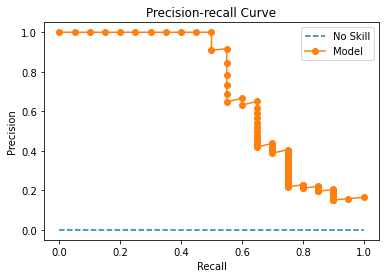

In [ ]:
def testing(X_test,y_test):
    # logging.info("[Testing] Start ...")
    _test("/content/drive/MyDrive/google_cv/flicker_detection/models/model0.h5", X_test, y_test)
    # logging.info("[Testing] done.")

testing(X_test,y_test)